# Blank Label Fabric Analysis
### Final Project- Sam Hale
#### How can we improve fabric buying based on total items sold?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load the data
df = pd.read_csv('Fabric_Data1.csv')
df.head()

,SKU,Color,Fabric Type,In Stock,Weight,OOS Date,Times Rebought,Most Recent Rebought Date,Total Sale Price,Total Items,Avg Sale,Product Online,Suit,Shirt,Pants,Outerwear
0,710,Lavender,Herringbone,Y,Dress Shirt,NaN,5,11/1,16359.7453,378,43.28,Y,N,Y,N,N
1,787,Blue,Lightweight Oxford,N,Transitional Shirt,9/5/2018,1,5/16,4613.0819,73,63.19,N,N,Y,N,N
2,830,White,Oxford,Y,Casual Shirt,NaN,4,11/21,11385.4135,176,64.69,N,N,Y,N,N
3,831,White,Textured Cotton,Y,Dress Shirt,NaN,4,9/25,15565.5830,260,59.87,Y,N,Y,N,N
4,844,Blue,Stripe Oxford,N,Casual Shirt,10/9/2018,1,6/26,4057.4988,67,60.56,N,N,Y,N,N


In [4]:
len(df)

498

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 16 columns):
SKU                          498 non-null object
Color                        498 non-null object
Fabric Type                  498 non-null object
In Stock                     498 non-null object
Weight                       498 non-null object
OOS Date                     264 non-null object
Times Rebought               498 non-null int64
Most Recent Rebought Date    142 non-null object
Total Sale Price             498 non-null float64
Total Items                  498 non-null int64
Avg Sale                     498 non-null float64
Product Online               498 non-null object
Suit                         498 non-null object
Shirt                        498 non-null object
Pants                        498 non-null object
Outerwear                    498 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 62.3+ KB


In [56]:
df.columns

Index(['SKU', 'Color', 'Fabric Type', 'In Stock', 'Weight', 'OOS Date',
       'Times Rebought', 'Most Recent Rebought Date', 'Total Sale Price',
       'Total Items', 'Avg Sale', 'Product Online', 'Suit', 'Shirt', 'Pants',
       'Outerwear'],
      dtype='object')

In [61]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [62]:
df.columns

Index(['sku', 'color', 'fabric_type', 'in_stock', 'weight', 'oos_date',
       'times_rebought', 'most_recent_rebought_date', 'total_sale_price',
       'total_items', 'avg_sale', 'product_online', 'suit', 'shirt', 'pants',
       'outerwear'],
      dtype='object')

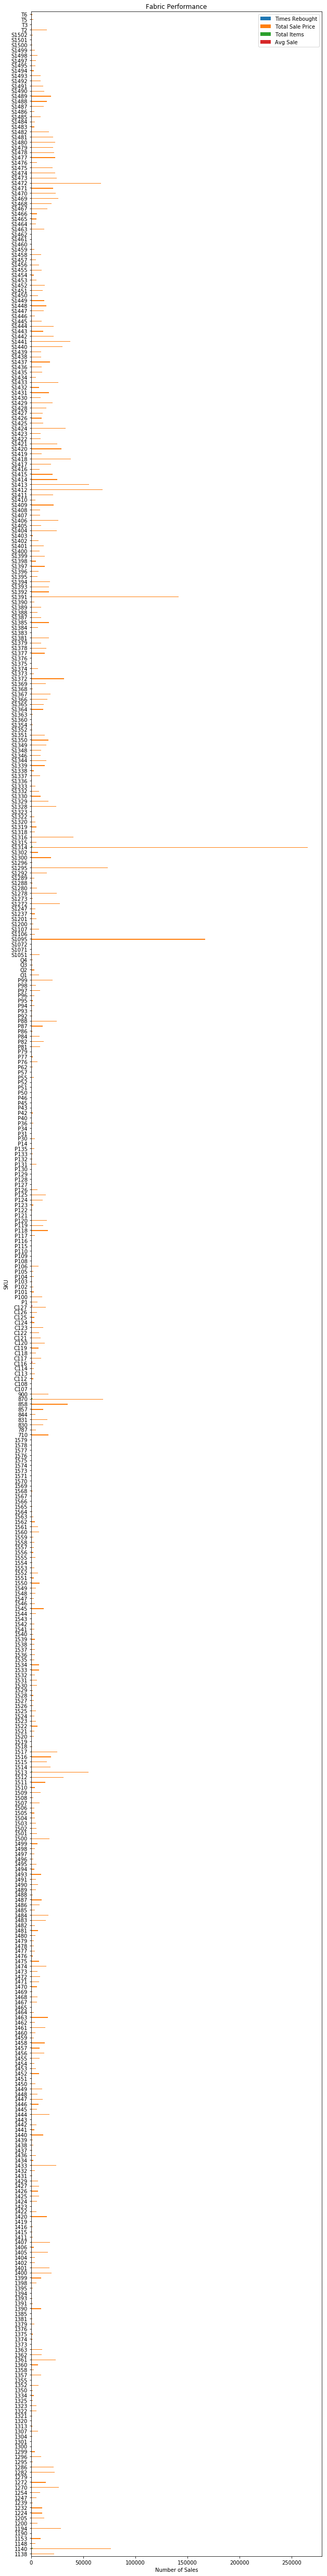

In [8]:
to_graph = df.groupby('SKU').sum().sort_values(by = 'SKU')
to_graph.plot(kind='barh', figsize= (10,90));
plt.title('Fabric Performance');
plt.xlabel('Number of Sales'); #A lot of rows! But very meaningful for work end because it displays all the different product categories.
#Any SKU containing "S" in the front is a suiting fabric that includes jacket, trouser, and vest sales
#Any SKU containing "P" in the front is a chino (cotton) fabric that also includes pant, trouser, jacket, and vest styles
#Show swatches of top performers

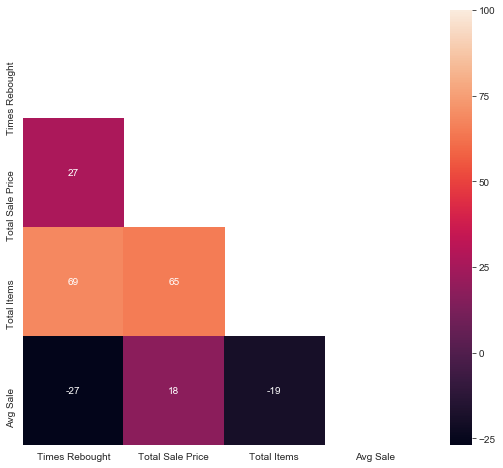

In [8]:
correlations = df.corr()
sns.set_style('whitegrid')
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9,8))
sns.heatmap(correlations*100, annot=True, fmt='.0f', mask=mask, cbar=True)
plt.show()

#Times Rebought and Avg Sale have 0 correlation
#Total Items and Times Rebought/Total Items and Total Sale Price have correlation

In [68]:
df.total_items.sort_values(ascending=False).head()

10     1446
7      1184
334     872
162     847
6       704
Name: total_items, dtype: int64

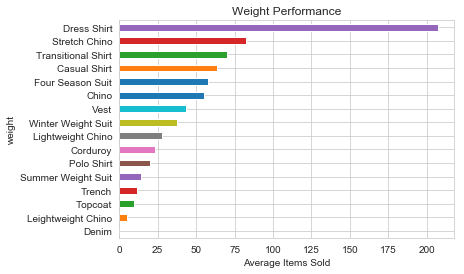

In [67]:
weight_sales_avg = df.groupby('weight')['total_items'].mean() #Aggregate the data
weight_sales_avg = weight_sales_avg.sort_values() #Sort the Aggregation
weight_sales_avg.plot(kind='barh')
plt.title('Weight Performance');
plt.xlabel('Average Items Sold');

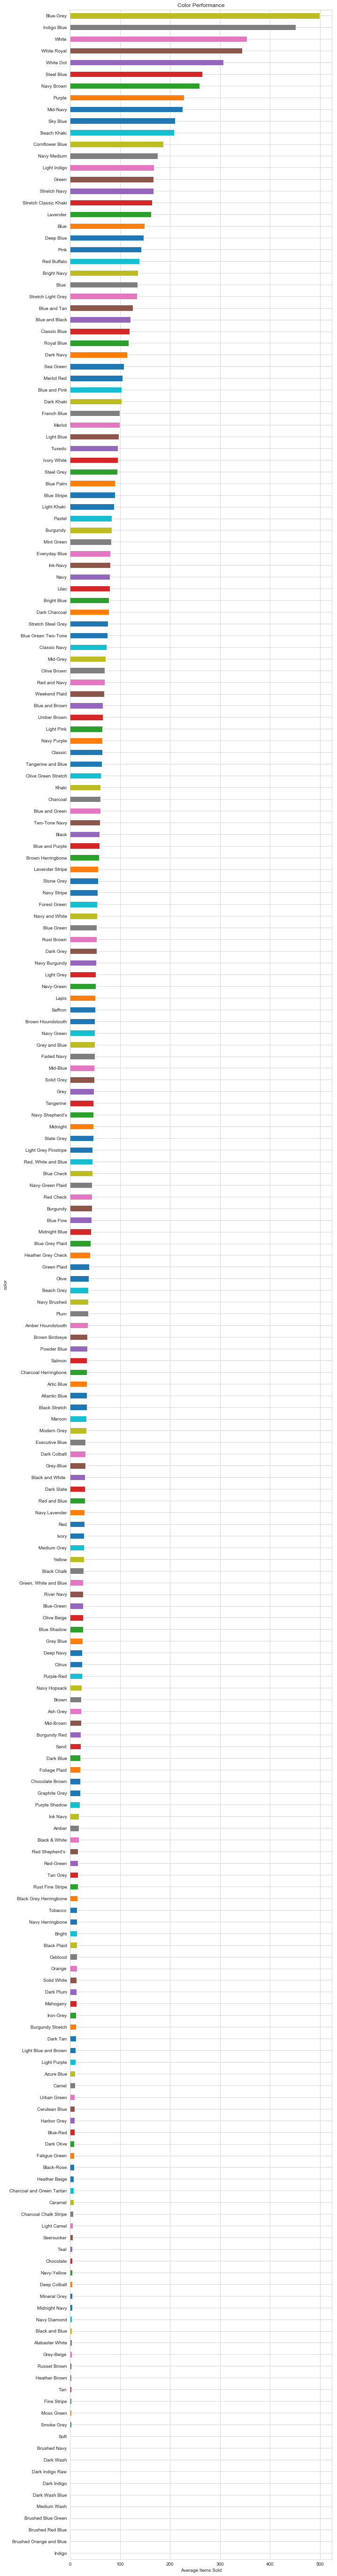

In [70]:
weight_sales_avg = df.groupby('color')['total_items'].mean() #Aggregate the data
weight_sales_avg = weight_sales_avg.sort_values() #Sort the Aggregation
weight_sales_avg.plot(kind='barh', figsize=(10,100))
plt.title('Color Performance');
plt.xlabel('Average Items Sold');

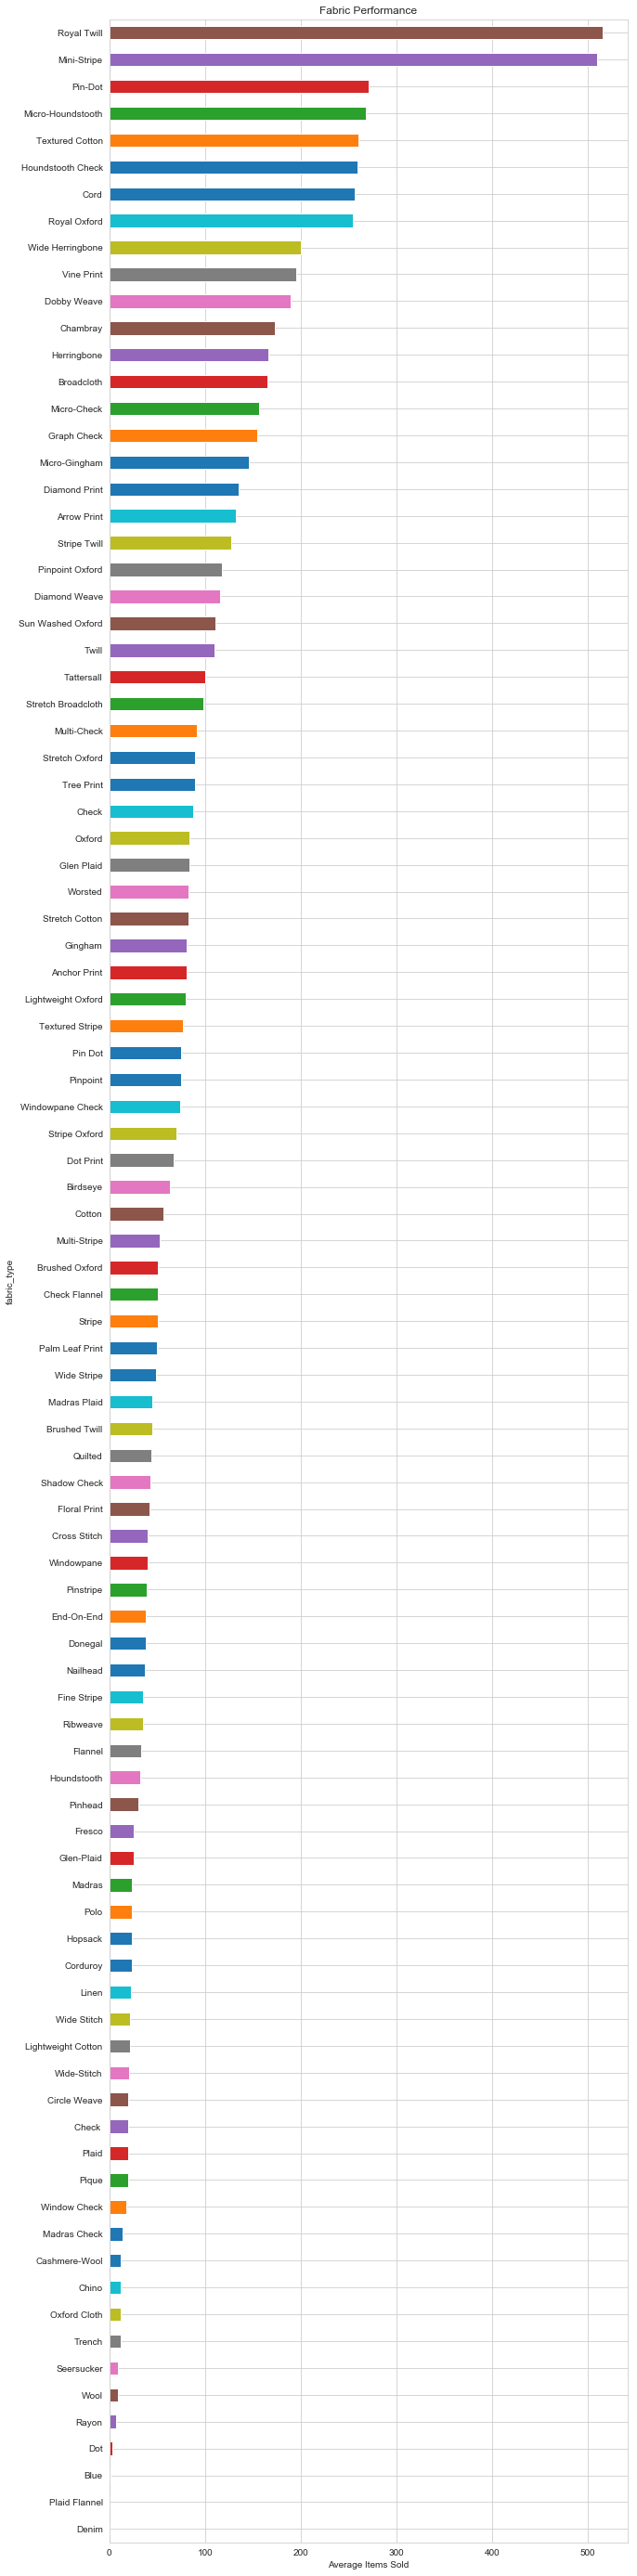

In [72]:
weight_sales_avg = df.groupby('fabric_type')['total_items'].mean() #Aggregate the data
weight_sales_avg = weight_sales_avg.sort_values() #Sort the Aggregation
weight_sales_avg.plot(kind='barh', figsize=(10,50))
plt.title('Fabric Performance');
plt.xlabel('Average Items Sold');

In [75]:
#Define the problem
y_feat = 'total_items' #chose total items because it had the highest correlation #total sales impacted by pricing (ex: topcoats most expensive)
x_feats = [feat for feat in df.columns if df[feat].dtype in [np.int64, np.float64] and feat != y_feat]
y = df[y_feat]
X = df[x_feats]

#Absolute Minimum Preprocessing
X = X.fillna(value = 0)

In [76]:
#Initial Models and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y)
models = [LinearRegression(), Lasso(), Ridge()]
names = ['OLS', 'Lasso', 'Ridge']
for model, name in list(zip(models, names)):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format(name))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('\n')

Model Stats for: OLS
Train R^2: 0.7848250393468339
Test R^2: 0.6288052473276636
Training MSE: 3099.8397445762294
Testing MSE: 9629.948444022108


Model Stats for: Lasso
Train R^2: 0.7847970766497219
Test R^2: 0.628474316962248
Training MSE: 3100.242578993444
Testing MSE: 9638.53380880588


Model Stats for: Ridge
Train R^2: 0.784824745179728
Test R^2: 0.6287728774408275
Training MSE: 3099.8439823875615
Testing MSE: 9630.788219743952




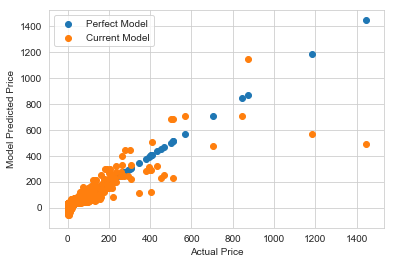

In [77]:
plt.scatter(y, y, label='Perfect Model')
plt.scatter(y, model.predict(X), label='Current Model')
plt.xlabel('Actual Price')
plt.ylabel('Model Predicted Price')
plt.legend()

#### Comments: Pretty good initial results- categorical variables we can still take advantage of

In [78]:
#Redefine the problem
y_feat = 'total_items'
x_feats = [feat for feat in df.columns if df[feat].dtype in [np.int64, np.float64] and feat != y_feat]
x_feats += ['sku', 'fabric_type', 'product_online'] #Chose these categories after looking into other combinations
#These provided best updated results

y = df[y_feat]
X = df[x_feats]
X = pd.get_dummies(X) #because they are categories 
print(X.columns)
X.head()

Index(['times_rebought', 'total_sale_price', 'avg_sale', 'sku_1138',
       'sku_1140', 'sku_1148', 'sku_1153', 'sku_1190', 'sku_1194', 'sku_1200',
       ...
       'fabric_type_Wide Stitch', 'fabric_type_Wide Stripe',
       'fabric_type_Wide-Stitch', 'fabric_type_Window Check',
       'fabric_type_Windowpane', 'fabric_type_Windowpane Check',
       'fabric_type_Wool', 'fabric_type_Worsted', 'product_online_N',
       'product_online_Y'],
      dtype='object', length=597)


,times_rebought,total_sale_price,avg_sale,sku_1138,sku_1140,sku_1148,sku_1153,sku_1190,sku_1194,sku_1200,...,fabric_type_Wide Stitch,fabric_type_Wide Stripe,fabric_type_Wide-Stitch,fabric_type_Window Check,fabric_type_Windowpane,fabric_type_Windowpane Check,fabric_type_Wool,fabric_type_Worsted,product_online_N,product_online_Y
0,5,16359.7453,43.28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,4613.0819,63.19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4,11385.4135,64.69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,15565.5830,59.87,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,4057.4988,60.56,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [79]:
#Second Models and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y)
models = [LinearRegression(), Lasso(), Ridge()]
names = ['OLS', 'Lasso', 'Ridge']
for model, name in list(zip(models, names)):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format(name))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('\n')

Model Stats for: OLS
Train R^2: 1.0
Test R^2: 0.7813462262634491
Training MSE: 3.028251316155356e-18
Testing MSE: 2140.8235794843254


Model Stats for: Lasso
Train R^2: 0.8575637227849902
Test R^2: 0.8449337037545934
Training MSE: 2822.3966301301703
Testing MSE: 1518.243100553333


Model Stats for: Ridge
Train R^2: 0.9431505146823538
Test R^2: 0.7979089874016966
Training MSE: 1126.481251282318
Testing MSE: 1978.658760738278




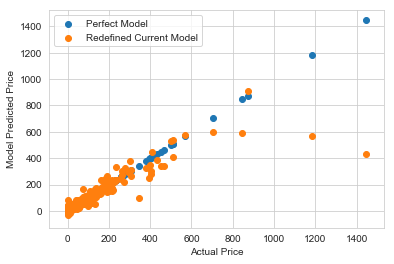

In [19]:
plt.scatter(y, y, label='Perfect Model')
plt.scatter(y, model.predict(X), label='Redefined Current Model')
plt.xlabel('Actual Price')
plt.ylabel('Model Predicted Price')
plt.legend() 

#### Comments: Better Train R^2 numbers- better looking graph!

# Impact of Normalization

In [20]:
#Third Round Models and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y)
models = [LinearRegression(normalize=True), Lasso(normalize=True), Ridge(normalize=True)]
names = ['OLS', 'Lasso', 'Ridge']
for model, name in list(zip(models, names)):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format(name))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('\n')

Model Stats for: OLS
Train R^2: 1.0
Test R^2: 0.8045401613404937
Training MSE: 8.319613888066013e-26
Testing MSE: 2897.9364047792888


Model Stats for: Lasso
Train R^2: 0.831188274766495
Test R^2: 0.8290360766537694
Training MSE: 3062.361012012242
Testing MSE: 2534.7538438932447


Model Stats for: Ridge
Train R^2: 0.8877591523237176
Test R^2: 0.7129378498344148
Training MSE: 2036.1263141147708
Testing MSE: 4256.055162555559




In [195]:
#Using Cross Validation
def run_cross_validation_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test) 
    print('Model Stats for: {}'.format('LassoCV'))
    print('Train R^2:', model.score(X_train, y_train))
    print('Test R^2:', model.score(X_test, y_test))
    print('Training MSE: {}'.format(mean_squared_error(y_train, y_hat_train)))
    print('Testing MSE: {}'.format(mean_squared_error(y_test, y_hat_test)))
    print('Model details:', model)
    print('Cross Validation Optimal Alpha Value for Regularization', model.alpha_)
    print('\n')    


for model in [LassoCV(normalize=True), RidgeCV(normalize=True)]:
    run_cross_validation_model(model, X, y)

Model Stats for: LassoCV
Train R^2: 0.9352811271355339
Test R^2: 0.6924044651122753
Training MSE: 1256.8031493676692
Testing MSE: 3385.795100787513
Model details: LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)
Cross Validation Optimal Alpha Value for Regularization 0.3650429252556796


Model Stats for: LassoCV
Train R^2: 0.9976058887527547
Test R^2: 0.4313156581037349
Training MSE: 36.09133344837223
Testing MSE: 13628.592717577574
Model details: RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)
Cross Validation Optimal Alpha Value for Regularization 0.1




# Attempt Additional Feature Engineering

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [1]:
def plot_polynomial_reg(model, X, y, degree_min=2, degree_max=7):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    degrees = []
    train_errs = []
    test_errs = []
    for degree in range(degree_min,degree_max+1):
        model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), model)
        #Could replace Ridge() above with a more complicated cross validation method to improve tuning
        #using a cross validation method will substantially increase runtime
        model.fit(X_train,y_train)
        #Get r^2 values for testing predictions and training predictions
        test_score = model.score(X_test,y_test)
        test_errs.append(test_score)
        
        train_score = model.score(X_train,y_train)
        train_errs.append(train_score)
        
        degrees.append(degree)
    #Create Plot
    plt.scatter(degrees, train_errs, label='Train R^2')
    plt.scatter(degrees, test_errs, label='Test R^2')
    plt.title('Train and Test Accuracy vs Model Complexity')
    plt.xlabel('Maximum Degree of Polynomial Regression')
    plt.legend()

for model in [Ridge(), Lasso()]:
    plot_polynomial_reg(Ridge(), X, y)

NameError: name 'Ridge' is not defined